BOS-PIV project

Analysis of the new BOS data collected on Feb. 21st, 2021

Jupyter notebooks are copied from the Git repository managed from Alex linux machine, https://alexlib@bitbucket.org/alexlib/piv_bos.git


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install watermark
!pip install openpiv
!pip install pivpy

  Found existing installation: importlib-metadata 3.7.0
    Uninstalling importlib-metadata-3.7.0:
      Successfully uninstalled importlib-metadata-3.7.0
     |████████████████████████████████| 88.4MB 79kB/s 
     |████████████████████████████████| 163kB 57.8MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 3.7MB 11.9MB/s 
     |████████████████████████████████| 8.1MB 56.7MB/s 
  Created wheel for readim: filename=ReadIM-0.8.4-cp37-cp37m-linux_x86_64.whl size=8330408 sha256=c99d15d0b148962663f6eba3b464a14f7d4456970140659fddc590028edeca47
  Stored in directory: /root/.cache/pip/wheels/76/39/c1/52564feb138514d177bd3df739b6be841b9d8057526ad5183a
Successfully built readim


In [ ]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy  : 1.19.5
openpiv: 0.23.4

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.112+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [ ]:
from openpiv import windef
from openpiv import tools, pyprocess, scaling, validation, filters, preprocess
import numpy as np
import os, glob
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [ ]:
settings = windef.Settings()


'Data related settings'
# Folder with the images to process
settings.filepath_images = '/gdrive/Shareddrives/OpenPIV_BOS/20210307-Run1/'
settings.save_path = '/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Run1'
# Format and Image Sequence
# settings.frame_pattern_a = '20210221-tare000001.tif'
settings.frame_pattern_a = '20210307-tare1000001.tif'
# settings.frame_pattern_a = '20210301-Run2000001.tif'
settings.frame_pattern_b = '20210307-Run1012018.tif'



'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
# settings.ROI = (100,400,600,1024)
# settings.ROI = [0,980,320,700]
settings.ROI = 'full'

settings.deformation_method = 'symmetric' 
# settings.deformation_method = 'second image'


settings.num_iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 8)
settings.overlap=(32, 16, 8, 4)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)

# 'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
settings.sig2noise_threshold = 1.0
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
settings.sig2noise_validate = False

# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = False
settings.scale_plot = 20  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
# settings.normalized_correlation = True

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True

settings.replace_vectors = True

settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 2
settings.filter_kernel_size = 1  # kernel size for the localmean method



settings.MinMax_U_disp = (-10, 10)
settings.MinMax_V_disp = (-10, 10)

# The second filter is based on the global STD threshold
settings.std_threshold = 5  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 5  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size = 2 # defines the size of the local median, it'll be 3 x 3

# New settings for version 0.23.2c
settings.image_mask = False

# Image mask properties
settings.dynamic_masking_method = None
# settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21



# Smoothing after the first pass
settings.smoothn = True #Enables smoothing of the displacemenet field
settings.smoothn_p = 0.05 # This is a smoothing parameter


settings.show_all_plots = False

settings.invert = True

#settings.remove_mean_shift = False

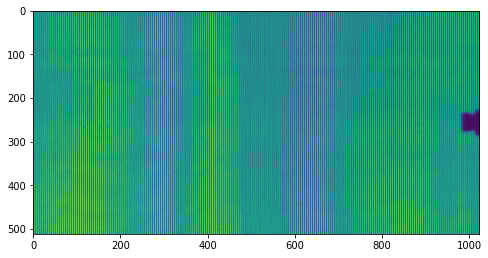

In [ ]:
# a = tools.imread('/gdrive/Shareddrives/OpenPIV_BOS/20210125-Run1/20210125-Run1000002.tif')
a = tools.imread(os.path.join(settings.filepath_images,settings.frame_pattern_a))
b = tools.imread(os.path.join(settings.filepath_images,settings.frame_pattern_b))
plt.imshow(a)#[0:980,320:700])
# plt.imshow(a[70:470,:980])

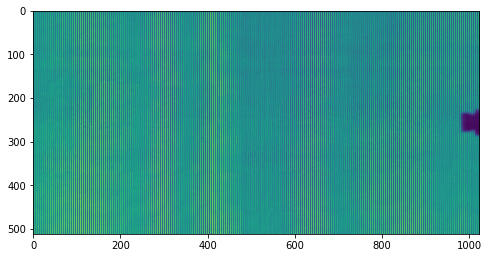

In [ ]:
plt.imshow(b)

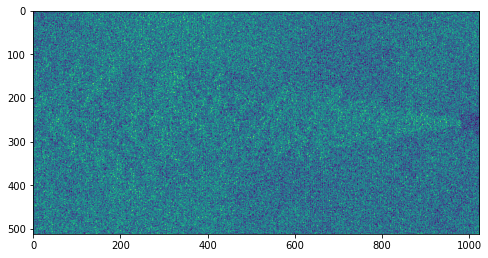

In [ ]:
plt.imshow(np.abs(a-b)*100)

In [ ]:
windef.piv(settings)

Image Pair 1
20210307-tare1000001.tif 20210307-Run1012018.tif


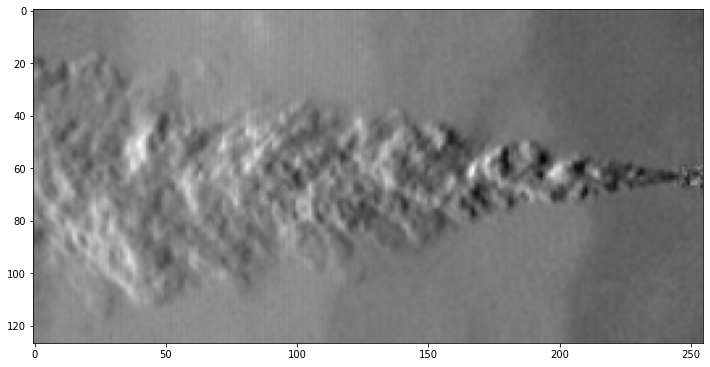

In [ ]:
import xarray as xr
from pivpy import pivpy, io, graphics

d = io.load_txt('/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12294.txt')

d.attrs['units'] = ['pix','pix','pix/dt','pix/dt']
# d.piv.quiver(arrScale=20)

plt.figure(figsize=(12,12))
plt.imshow(d['u'].isel(t=0).T,cmap=plt.cm.gray)

In [ ]:
import glob
imlist = glob.glob(os.path.join(settings.filepath_images,settings.frame_pattern_b[:-10]+'*.tif'))
imlist.sort()
# imlist[:-1]

In [1]:
print(len(imlist))
imlist[:5],imlist[-5:]

NameError: ignored

In [ ]:
duplicates = [f.endswith('(1).tif') for f in imlist]

SyntaxError: ignored

In [ ]:
np.where(np.array(duplicates))

(array([11139, 11141, 11144, 11146, 11149, 11151]),)

In [ ]:
last_item = 12017 # or 6057
imlist[last_item]

'/gdrive/Shareddrives/OpenPIV_BOS/20210307-Run1/20210307-Run1012012.tif'

In [2]:
# windef generates a default file name for every pair:
res_file = glob.glob(os.path.join(settings.save_path,'Open_PIV_results_8_Run1/*.txt'))[-1]
print(res_file)
print(res_file.replace('000',f"{counter+last_item+1:d}"))

NameError: ignored

In [ ]:
# remove plot options
settings.show_plot = False
settings.show_all_plots = False

# for all the list, do PIV with the tare image
for counter,im in enumerate(imlist[last_item:]):
    settings.frame_pattern_b = im
    windef.piv(settings)
    print(res_file.replace('000',f"{counter+last_item+1:d}"))
    os.rename(res_file,res_file.replace('000',f"{counter+last_item+1:d}"))

Image Pair 1
20210307-tare1000001.tif 20210307-Run1012012.tif
/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12018.txt
Image Pair 1
20210307-tare1000001.tif 20210307-Run1012013.tif
/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12019.txt
Image Pair 1
20210307-tare1000001.tif 20210307-Run1012014.tif
/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12020.txt
Image Pair 1
20210307-tare1000001.tif 20210307-Run1012015.tif
/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12021.txt
Image Pair 1
20210307-tare1000001.tif 20210307-Run1012016.tif
/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12022.txt
Image Pair 1
20210307-tare1000001.tif 20210307-Run1012017.tif
/gdrive/Shareddrives/OpenPIV_BOS/results_20210307-Run1/Open_PIV_results_8_Run1/field_A12023.txt
Image Pair 1
20210307-tare1000001.tif 20210307-Run10